# Developing trading strategies for different AI & Computing stocks

## Initial set up
The following modules were imported:
1. Yahoo Finance to extract financial data
2. Pandas to store daily returns of each company in a dataframe
3. Matplotlib and seaborn for plotting purposes.
4. Datetime for current time
5. Transformers and torch to use finbert model

In [1]:
# Import required libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta



In [19]:
pd.__version__

'2.1.2'

In [3]:
# Set plotting style
#plt.style.use('seaborn')
#sns.set_palette("husl")

In [4]:
# Define the companies and their tickers
companies = {
    'NVIDIA': 'NVDA',
    'Microsoft': 'MSFT',
    'Apple': 'AAPL',
    'Alphabet': 'GOOGL',
    'Amazon': 'AMZN',
    'Meta': 'META',
    'AMD': 'AMD'
}

In [5]:
# Download one year of data
end_date = datetime.now()
start_date = end_date - timedelta(days=730)

# Indicators that I calculated
1. Volatility : computed by finding standard deviation of closing prices for the last 30 days.
2. 20 and 50 Day Moving Average : computed by finding mean of closing prices for the last 20 and 50 days respectively.
3. Daily return : percentage change between closing prices of the final 2 consecutive days.

In [6]:
# Function to calculate technical indicators
def calculate_indicators(df):
    # Calculate moving averages
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    
    # Calculate volatility (30-day rolling standard deviation)
    df['Volatility'] = df['Close'].rolling(window=30).std()
    
    # Calculate daily returns
    df['Daily_Return'] = df['Close'].pct_change()
    
    return df

In [7]:
# Download and process data for all companies
dfs = {}
for company, ticker in companies.items():
    # Download data
    stock = yf.download(ticker, start=start_date, end=end_date)
    
    # Calculate indicators
    stock = calculate_indicators(stock)
    
    # Store in dictionary
    dfs[company] = stock

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


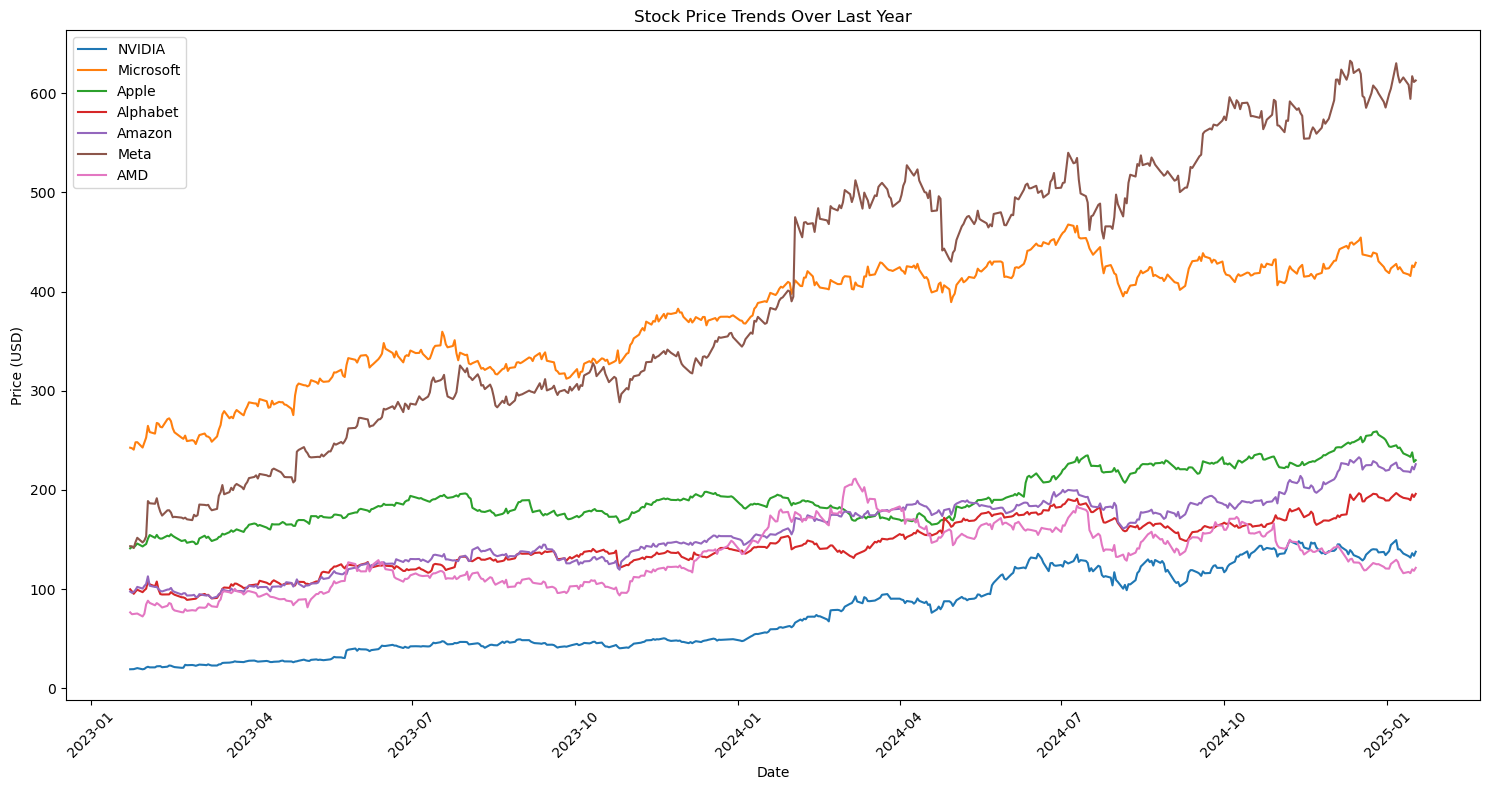

In [8]:
# 1. Price Trend Analysis
plt.figure(figsize=(15, 8))
for company, df in dfs.items():
    plt.plot(df.index, df['Close'], label=company)
plt.title('Stock Price Trends Over Last Year')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The trend analysis shows that META, Microsoft, and NVIDIA grew significantly over the last year. Apple, Alphabet, and Amazon also grew, though not as much as the aforementioned companies. AMD grew only slightly over the last year.

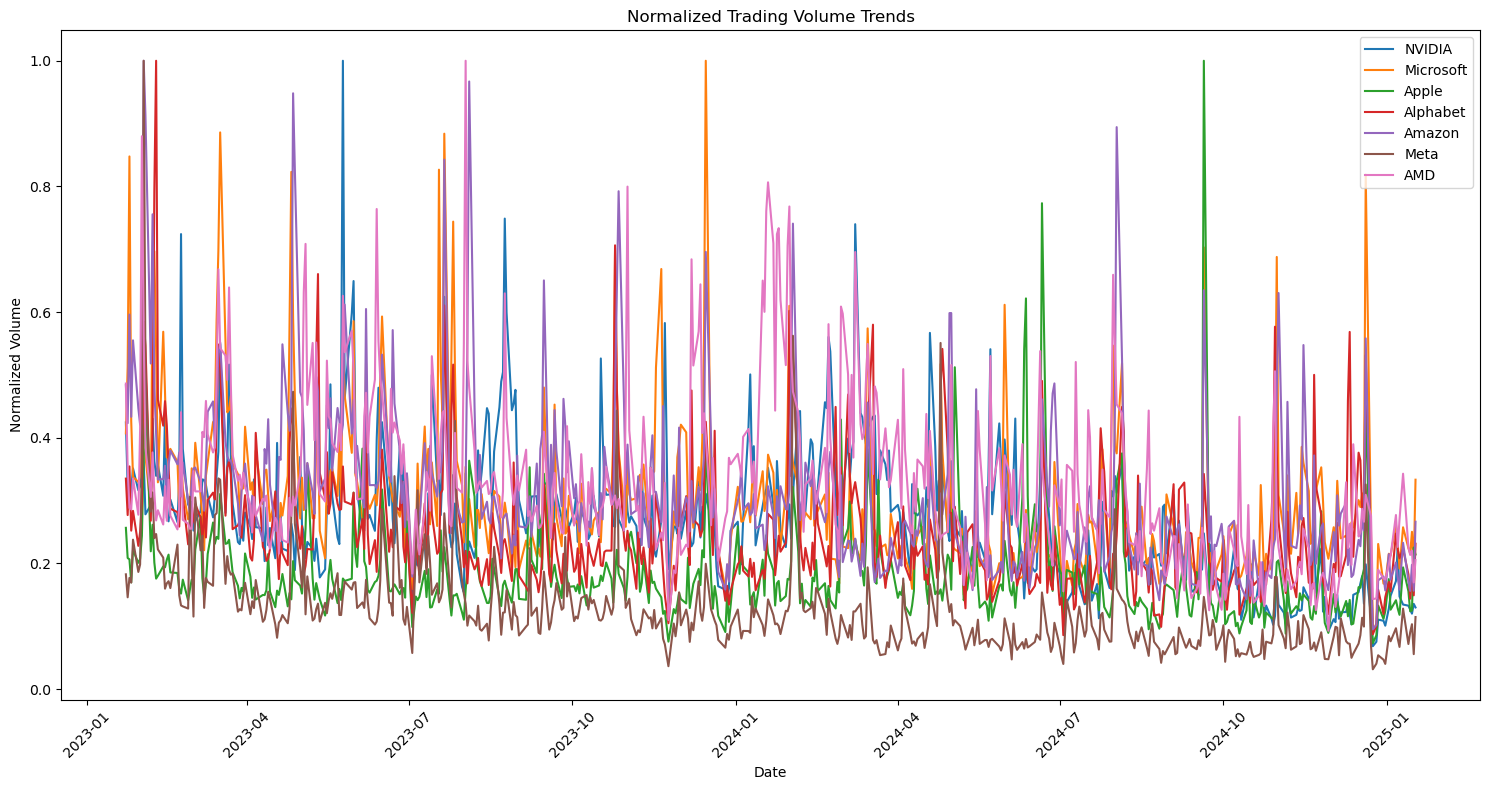

In [9]:
# 2. Volume Analysis
plt.figure(figsize=(15, 8))
for company, df in dfs.items():
    # Normalize volume for better comparison
    normalized_volume = df['Volume'] / df['Volume'].max()
    plt.plot(df.index, normalized_volume, label=company)
plt.title('Normalized Trading Volume Trends')
plt.xlabel('Date')
plt.ylabel('Normalized Volume')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The volume analysis tells us that all the stocks have very high peaks that occur at random times, which mostly occur during changes in the news. For example, there seems to be a very high spike in volume of stock traded near around 2024-10, which could be due to the results of the US Presidential elections that were announced around then.

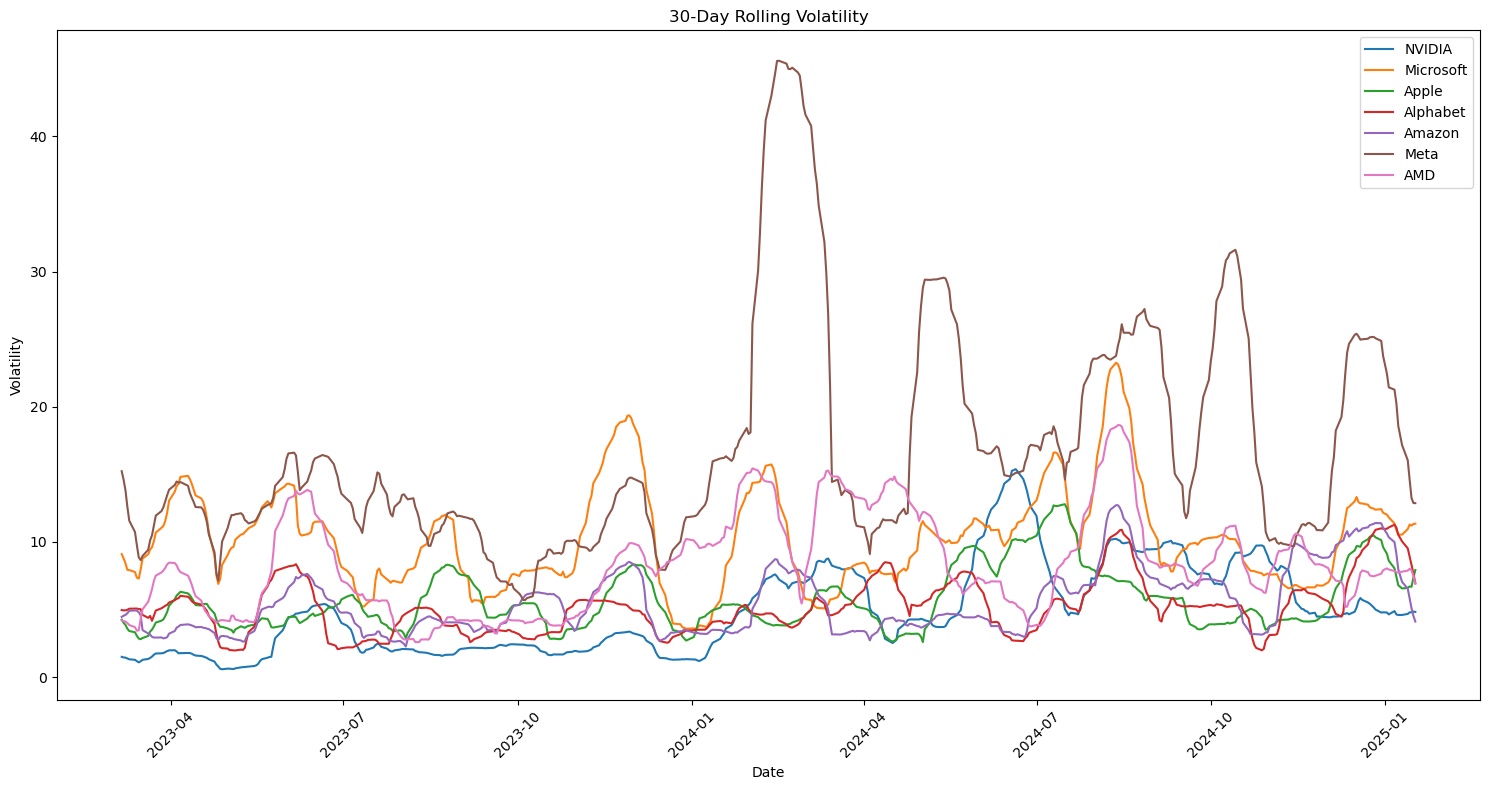

In [10]:
# 3. Volatility Comparison
plt.figure(figsize=(15, 8))
for company, df in dfs.items():
    plt.plot(df.index, df['Volatility'], label=company)
plt.title('30-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Here we see that META is much more volatile than the other stocks, and microsoft is also almost always second most volatile (right after META). 

Notable, NVIDIA and AMD have a very rapidly changing volatility as well.

The others have a more relatively stable volatility, with Apple being the most consistently stable.

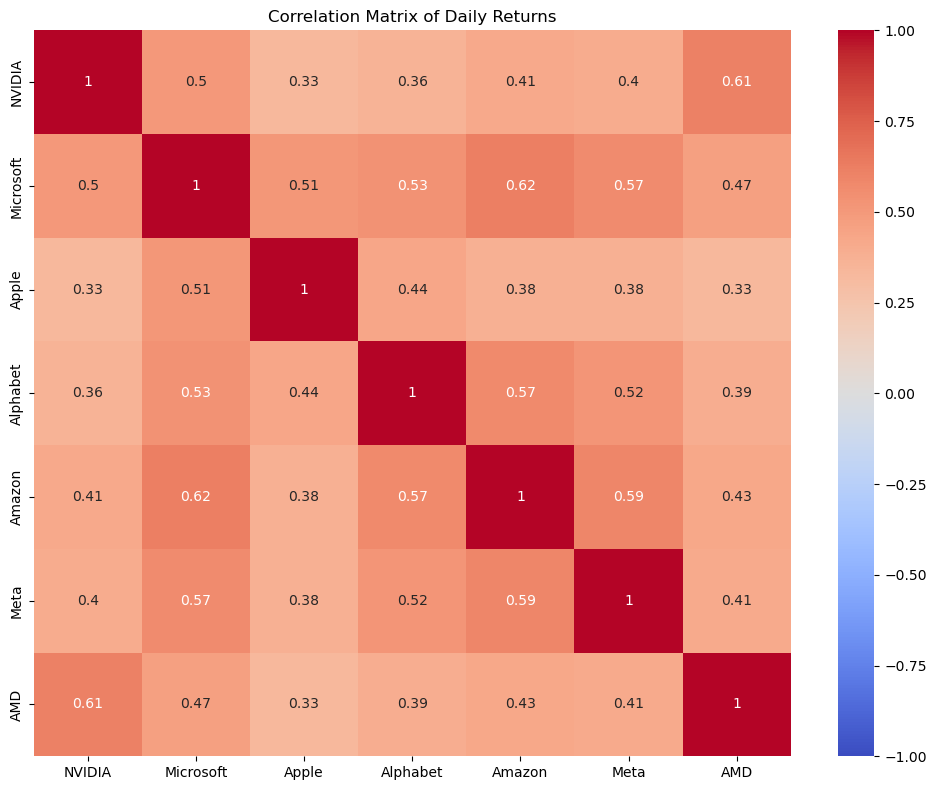

In [11]:

# 4. Correlation Analysis
# Calculate correlation matrix of daily returns
returns_df = pd.DataFrame()
for company, df in dfs.items():
    returns_df[company] = df['Daily_Return']

correlation_matrix = returns_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Daily Returns')
plt.tight_layout()
plt.show()

There seems to be a medium to high correlation between the following stocks:
1. NVIDIA and AMD with a correlation of 0.62.
2. Alphabet, Amazon, Meta and Microsoft all have moderate correlations with eachother(between 0.5 and 0.65)

In [12]:
def calculate_rsi(data, periods=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(data, fast=12, slow=26, signal=9):
    exp1 = data['Close'].ewm(span=fast, adjust=False).mean()
    exp2 = data['Close'].ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

def calculate_bollinger_bands(data, window=20, num_std=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, rolling_mean, lower_band


class TradingStrategies:
    @staticmethod
    def apple_strategy(data):
        """
        Fixed Apple strategy with less restrictive conditions:
        - Simplified gap analysis
        - More lenient signal generation
        - Focus on trend following with volume confirmation
        """
        # Core indicators
        data['MA20'] = data['Close'].rolling(window=20).mean()
        data['MA50'] = data['Close'].rolling(window=50).mean()
        
        # MACD with less filtering
        exp1 = data['Close'].ewm(span=12, adjust=False).mean()
        exp2 = data['Close'].ewm(span=26, adjust=False).mean()
        data['MACD'] = exp1 - exp2
        data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
        data['MACD_Hist'] = data['MACD'] - data['Signal_Line']
        
        # Volume analysis
        data['Volume_MA'] = data['Volume'].rolling(window=20).mean()
        data['Volume_Ratio'] = data['Volume'] / data['Volume_MA']
        
        # Price momentum
        data['Momentum'] = data['Close'].pct_change(5)
        
        # Generate signals
        data['Signal'] = 0
        
        # Buy conditions - Less restrictive
        buy_condition = (
            (data['Close'] > data['MA20']) &  # Above short-term MA
            (
                (data['MACD'] > data['Signal_Line']) |  # Either MACD crossover
                (data['Momentum'] > 0.005)  # Or positive momentum
            ) &
            (data['Volume_Ratio'] > 0.8)  # Reasonable volume
        )
        
        # Sell conditions - More responsive
        sell_condition = (
            (data['Close'] < data['MA20']) |  # Below short-term MA
            (
                (data['MACD'] < data['Signal_Line']) &  # MACD crossunder with
                (data['Momentum'] < -0.005)  # negative momentum
            )
        )
        
        data.loc[buy_condition, 'Signal'] = 1
        data.loc[sell_condition, 'Signal'] = -1
        
        return data

    @staticmethod
    def alphabet_amazon_strategy(data, correlation_data=None):

        # Core trend indicators
        data['MA20'] = data['Close'].rolling(window=20).mean()
        data['MA50'] = data['Close'].rolling(window=50).mean()
        
        # RSI for oversold/overbought
        data['RSI'] = calculate_rsi(data)
        
        # Enhanced momentum
        data['Momentum'] = data['Close'].pct_change(10)
        data['Momentum_MA'] = data['Momentum'].rolling(window=10).mean()
        
        # Volume trend
        data['Volume_MA'] = data['Volume'].rolling(window=20).mean()
        data['Volume_Trend'] = data['Volume'] / data['Volume_MA']
        
        # Generate signals
        data['Signal'] = 0
        
        # Buy conditions
        buy_condition = (
            (data['Close'] > data['MA20']) &  # Above short-term MA
            (data['MA20'] > data['MA50']) &   # Upward trend
            (data['RSI'] < 65) &              # Not overbought
            (data['Momentum'] > 0) &          # Positive momentum
            (data['Volume_Trend'] > 0.7)      # Decent volume
        )
        
        # Sell conditions - More balanced
        sell_condition = (
            (data['Close'] < data['MA20']) &  # Below short-term MA
            (
                (data['RSI'] > 70) |          # Overbought
                (data['Momentum'] < -0.01)     # Strong negative momentum
            )
        )
        
        
        data.loc[buy_condition, 'Signal'] = 1
        data.loc[sell_condition, 'Signal'] = -1
        
        return data

    @staticmethod
    def meta_microsoft_strategy(data):
        """Meta/Microsoft strategy unchanged"""
        data['RSI'] = calculate_rsi(data)
        data['BB_Upper'], data['BB_Middle'], data['BB_Lower'] = calculate_bollinger_bands(data)
        
        data['Signal'] = 0
        data.loc[(data['RSI'] < 30) & (data['Close'] < data['BB_Lower']), 'Signal'] = 1
        data.loc[(data['RSI'] > 70) & (data['Close'] > data['BB_Upper']), 'Signal'] = -1
        
        return data

    @staticmethod
    def nvidia_amd_strategy(data):
        """NVIDIA/AMD strategy unchanged"""
        data['RSI'] = calculate_rsi(data)
        data['Volume_MA'] = data['Volume'].rolling(window=20).mean()
        data['Price_MA'] = data['Close'].rolling(window=20).mean()
        data['Momentum'] = data['Close'].pct_change(periods=10)
        
        data['Signal'] = 0
        
        buy_condition = (
            (data['Momentum'] > 0.01) &  
            (data['RSI'] < 70)
        )
        
        sell_condition = (
            (data['Momentum'] < -0.015) |  
            (data['RSI'] > 75) |  
            (data['Close'] < data['Price_MA'] * 0.95)  
        )
        
        data.loc[buy_condition, 'Signal'] = 1
        data.loc[sell_condition, 'Signal'] = -1
        
        return data

## 1. Relative Strength Index (RSI)
RSI is a momentum oscillator that measures the speed and change of price movements. It's often used to identify whether an asset is overbought or oversold.

### Logic:
1. Delta Calculation: The first step is to calculate the change in price between each consecutive period.
2. Gains and Losses: Then, you separate the gains (positive changes) and losses (negative changes).
3. Gains: You use .where(delta > 0, 0) to keep positive values and set the others to zero.
Losses: Similarly, you use .where(delta < 0, 0) to keep negative values and set the others to zero. Losses are negated (i.e., -delta) because we are interested in positive values for further calculations.
4. Rolling Mean of Gains and Losses: Calculate the rolling average of gains and losses over a specified period.
5. RS (Relative Strength): RS is the ratio of the average gain to the average loss.
6. RSI Calculation: Finally, RSI is calculated using the formula: RSI = 100 - 100/(1+RS)
RSI is a value between 0 and 100, where values over 70 typically indicate overbought conditions and values under 30 indicate oversold conditions.

## 2. Moving Average Convergence Divergence (MACD)
MACD is a trend-following momentum indicator that shows the relationship between two moving averages of an asset's price. The most common periods used for MACD are 12 and 26 days.

### Logic:
1. Exponential Moving Averages (EMA): MACD is calculated using the difference between a short-term EMA (12-day) and a long-term EMA (26-day).
2. MACD Line: The MACD line is simply the difference between exp1 and exp2.
3. Signal Line: A 9-day EMA of the MACD line is used to smooth the MACD, and it is referred to as the signal line.

Interpretation: When the MACD crosses above the signal line, it’s considered a bullish signal, and when the MACD crosses below the signal line, it’s considered a bearish signal.

## 3. Bollinger Bands
Bollinger Bands are a volatility indicator. They consist of three lines:

The middle band is a simple moving average (SMA) of the closing prices.
The upper and lower bands are defined as the middle band ± (2 * standard deviation of the price).
### Logic:
1. Rolling Mean: The middle band is calculated as the rolling mean of the closing prices over a specified window.
2. Rolling Standard Deviation: The upper and lower bands are based on the rolling standard deviation of the closing prices.
3. Upper and Lower Bands: The upper band is the middle band + (num_std * rolling standard deviation), and the lower band is the middle band - (num_std * rolling standard deviation).

Interpretation: If the price touches or exceeds the upper band, it is often considered overbought; if it touches or falls below the lower band, it is often considered oversold.


# Logic behind this trading strategy:
## Apple Strategy
The Apple Strategy focuses on trend-following with volume confirmation and uses relatively less restrictive conditions compared to typical strategies. This is because Apple stock is more stable/ less volatile than the others, so strict conditions may not be required.

### Core Indicators:

20-period and 50-period Moving Averages (MA20, MA50): Used to determine the short-term and long-term trend. The price should be above MA20 for bullish conditions.
MACD and Signal Line: MACD is used to identify potential trend reversals, and the Signal Line helps in confirming bullish or bearish trends based on crossovers.
Volume Analysis: Volume is checked against its 20-period moving average to identify significant volume spikes.
Momentum: This is measured as the percentage change in price over 5 periods to capture short-term price movements.

### Buy Conditions:

The price is above the 20-period moving average (indicating a short-term bullish trend).
Either MACD is above the Signal Line (bullish crossover) or momentum is positive (>0.5%).
The volume ratio (current volume vs. 20-period moving average of volume) is greater than 0.8 (indicating a reasonable amount of volume).

### Sell Conditions:

The price falls below the 20-period moving average (indicating a bearish trend).
Alternatively, if MACD crosses below the Signal Line and momentum turns negative (<-0.5%).

The strategy is designed to follow the trend with volume confirmation, but with relatively lenient buy and sell signals to allow for more flexibility.

## Alphabet/Amazon Strategy
This strategy targets long-term trends using momentum and relative strength indicators, with a focus on large tech stocks like Alphabet and Amazon. I chose the same strategies for these companies because they have a moderate positive correlation.

### Core Indicators:

20-period and 50-period Moving Averages (MA20, MA50): To determine the overall trend direction, with buy conditions focusing on price above MA20 and MA20 above MA50.
RSI: To assess overbought or oversold conditions. An RSI below 65 signals that the stock is not overbought.
Momentum: The percentage change in price over 10 periods, indicating the strength of recent price movements.
Volume Trend: The volume is compared with its 20-period moving average to identify volume trends, ensuring there’s sufficient volume behind price movements.

### Buy Conditions:

The price is above the 20-period moving average, and the 20-period moving average is above the 50-period moving average (indicating a strong uptrend).
RSI is below 65 (not overbought).
Momentum is positive (indicating the stock is moving in the right direction).
Volume Trend is greater than 0.7, suggesting that the trade is supported by sufficient volume.

### Sell Conditions:

The price is below the 20-period moving average (indicating a bearish trend).
Alternatively, RSI is above 70 (overbought) or momentum is negative (indicating weakening price movement).

This strategy aims to capitalize on strong trends with a combination of trend-following and volume confirmation while avoiding overbought conditions. This is because Amazon and Alphabet have a slightly greater volatility than Apple, but are still more stable in the long run.

## Meta/Microsoft Strategy
The Meta/Microsoft Strategy uses RSI and Bollinger Bands to capture overbought and oversold conditions for short-term trading. I chose this strategy for these stocks because they were the most volatile ones, so it would be a good idea to use Bollinger Bands to detect how under/overvalued the stock is.

### Core Indicators:

RSI: Used to detect overbought or oversold conditions (values >70 suggest overbought, values <30 suggest oversold).
Bollinger Bands: Price bands that define the volatility of the stock. The strategy uses the upper and lower bands to detect overbought and oversold conditions.

### Buy Conditions:

RSI is below 30 (indicating oversold).
The price is below the lower Bollinger Band, suggesting the stock is undervalued.

### Sell Conditions:

RSI is above 70 (indicating overbought).
The price is above the upper Bollinger Band, suggesting the stock is overvalued.

This strategy is simple and effective for short-term mean reversion trades, buying when the stock is oversold and selling when it is overbought. 

## NVIDIA/AMD Strategy
The NVIDIA/AMD Strategy combines momentum, volume, and RSI to capture short-term price movements with trend-following behavior. This is because both of these stocks have very varying volatility,and momentum is good for capturing strong price movements.

### Core Indicators:

RSI: To check if the stock is overbought or oversold.
Volume Moving Average (Volume_MA): To determine whether current trading volume is unusually high.
Price Moving Average (Price_MA): To track the trend in the stock's price.
Momentum: The percentage change in the stock's price over 10 periods to capture price momentum.
### Buy Conditions:

Momentum is greater than 1% (positive momentum).
Volume is at least 20% higher than the Volume Moving Average (indicating strong buying interest).
RSI is below 70 (not overbought).
The price is above the Price Moving Average (indicating an uptrend).
### Sell Conditions:

Momentum is less than -1.5% (negative momentum).
RSI is above 75 (overbought).
The price is below 95% of the Price Moving Average (indicating a downtrend).

This strategy aims to buy stocks with strong momentum and higher-than-average volume while selling when momentum wanes or the stock becomes overbought or starts a downtrend.



In [13]:
def calculate_daily_returns(portfolio_values):
    """Calculate daily returns from portfolio values"""
    returns = pd.Series(portfolio_values).pct_change().dropna()
    return returns

def calculate_sharpe_ratio(returns, risk_free_rate=0.02):
    """
    Calculate Sharpe Ratio properly
    
    Parameters:
    returns: Series of returns (not portfolio values)
    risk_free_rate: Annual risk-free rate (default 2%)
    
    Returns:
    float: Annualized Sharpe Ratio
    """
    if len(returns) == 0 or returns.std() == 0:
        return 0
    
    # Convert annual risk-free rate to daily
    daily_rf = (1 + risk_free_rate) ** (1/252) - 1
    
    # Calculate excess returns
    excess_returns = returns - daily_rf
    
    # Calculate annualized Sharpe Ratio
    annual_excess_return = excess_returns.mean() * 252
    annual_volatility = excess_returns.std() * np.sqrt(252)
    
    if annual_volatility == 0:
        return 0
        
    sharpe = annual_excess_return / annual_volatility
    return sharpe


In [14]:
def evaluate_strategy(company, df, strategy_type):
    """
    Enhanced strategy evaluation with corrected metrics
    """
    # Apply strategy
    df_strategy = strategy_type(df.copy())
    
    # Initialize portfolio tracking
    initial_capital = 100000
    position = 0
    portfolio_value = initial_capital
    portfolio_values = [portfolio_value]
    trades = []
    returns = []
    
    # Track actual trade returns
    for i in range(1, len(df_strategy)):
        signal = df_strategy['Signal'].iloc[i]
        current_price = df_strategy['Close'].iloc[i]
        prev_price = df_strategy['Close'].iloc[i-1]
        daily_return = (current_price - prev_price) / prev_price * position
        # Calculate returns if in position
        if position != 0:
            
            returns.append(daily_return)
        else:
            returns.append(0)
            
        # Process signals
        if signal > 0 and position == 0:  # Buy
            position = 1  # Can be modified for position sizing
            trades.append({
                'Type': 'Buy',
                'Date': df_strategy.index[i],
                'Price': current_price
            })
        elif signal < 0 and position != 0:  # Sell
            if position > 0:
                trade_return = (current_price - trades[-1]['Price']) / trades[-1]['Price']
                trades[-1]['Profit'] = trade_return
            position = 0
            trades.append({
                'Type': 'Sell',
                'Date': df_strategy.index[i],
                'Price': current_price
            })
            
        # Update portfolio value
        if position != 0:
            portfolio_value = portfolio_value * (1 + daily_return)
        portfolio_values.append(portfolio_value)
    
    # Calculate metrics
    returns_series = pd.Series(returns).dropna()
    total_return = (portfolio_value - initial_capital) / initial_capital * 100
    
    # Calculate max drawdown
    peak = pd.Series(portfolio_values).expanding(min_periods=1).max()
    drawdown = (pd.Series(portfolio_values) - peak) / peak * 100
    max_drawdown = drawdown.min()
    
    # Calculate win rate
    profitable_trades = sum(1 for trade in trades 
                          if 'Profit' in trade and trade['Profit'] > 0)
    win_rate = (profitable_trades / len(trades) * 100) if trades else 0
    
    return {
        'Final Value': portfolio_value,
        'Return (%)': total_return,
        'Max Drawdown (%)': max_drawdown,
        'Sharpe Ratio': calculate_sharpe_ratio(returns_series),
        'Number of Trades': len(trades),
        'Win Rate (%)': win_rate,
        'Portfolio Values': portfolio_values,
        'Trades': trades
    }

# Logic for evaluating/ backtesting strategies:

## Daily Returns Calculation:

The function calculate_daily_returns computes the daily returns of a portfolio based on its portfolio values. It uses percentage change (pct_change) and drops any missing values (dropna()).

## Sharpe Ratio Calculation:

The Sharpe Ratio measures the risk-adjusted return of the strategy.
It is calculated using daily returns and compares the strategy's excess returns (over a daily risk-free rate) to its volatility (standard deviation of returns).
The formula annualizes the excess returns and volatility to give an overall annualized Sharpe Ratio.

## Strategy Backtesting:

The evaluate_strategy function applies the chosen trading strategy to the company data and backtests the strategy using historical price data.
The backtest simulates trading decisions, generating portfolio values and a list of trades executed during the test.

## Key Performance Metrics:

1. Total Return: Measures the percentage change in the portfolio value from the initial capital to the final value.
2. Max Drawdown: Captures the largest peak-to-trough decline in the portfolio value during the period. It indicates the maximum loss from a peak before recovery.
3. Sharpe Ratio: Assesses risk-adjusted returns (as described above).
4. Win Rate: Represents the percentage of profitable trades out of the total number of trades executed. This is calculated by counting trades with positive profits.

## Results Aggregation:

The evaluation runs for multiple companies (Apple, Alphabet, Amazon, Meta, Microsoft, Nvidia, AMD), applying a different strategy for each company based on predefined conditions.
Results for each company include:
1. Final portfolio value
2. Return percentage
3. Maximum drawdown percentage
4. Sharpe ratio
5. Number of trades executed
6. Win rate percentage
7. Visualization in the form of a bar graph. I've also made plots to showcase where buy/sell signals are actually made


Enhanced Strategy Performance Summary:
                  NVIDIA  Microsoft  Apple  Alphabet  Amazon   Meta     AMD
Return (%)        130.59      25.13  59.17     75.15   66.13  20.10  172.33
Max Drawdown (%)  -11.39     -15.49  -6.69     -8.74  -11.56  -3.51   -9.84
Sharpe Ratio        1.73       0.95   0.72      0.81    0.68   1.46    0.57
Number of Trades   68.00       5.00  54.00     25.00   31.00   4.00   70.00
Win Rate (%)       25.00      40.00  14.81     20.00   19.35  50.00   21.43


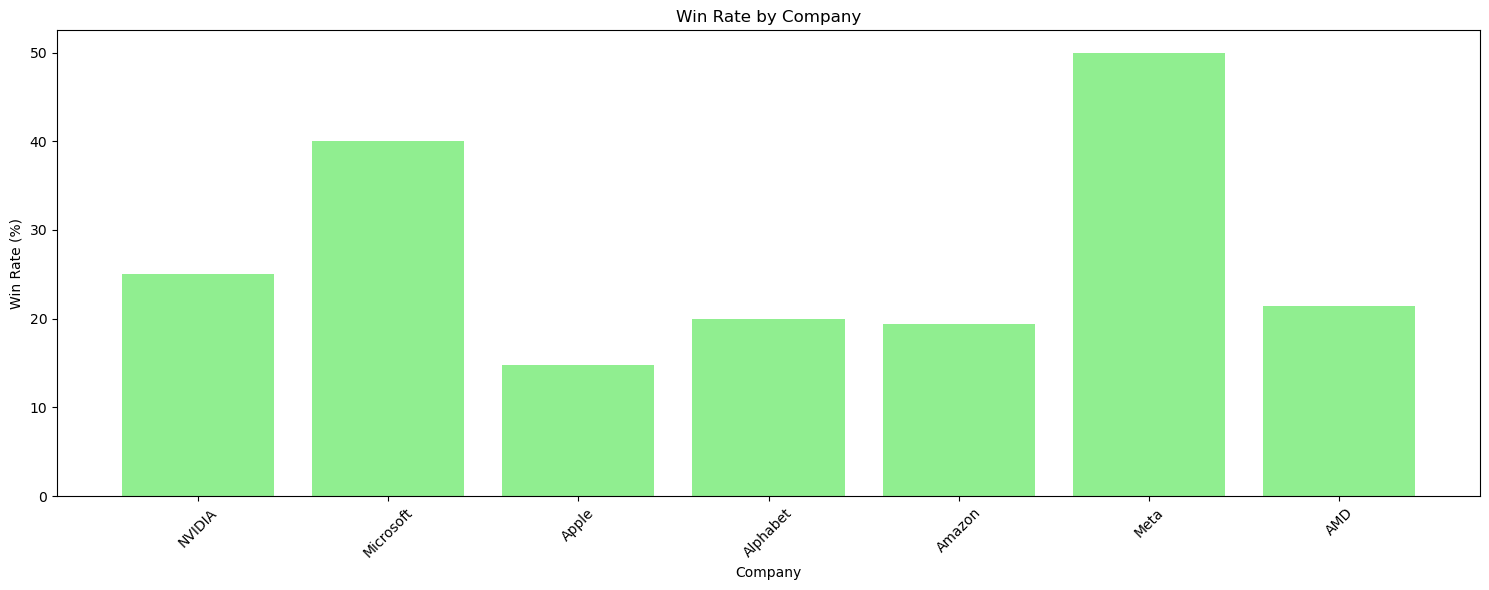

In [15]:

# Apply strategies and generate results
results = {}
for company, df in dfs.items():
# In your evaluation code:
    if company == 'Apple':
        strategy = TradingStrategies.apple_strategy
    elif company in ['Alphabet', 'Amazon']:
        strategy = TradingStrategies.alphabet_amazon_strategy
    elif company in ['Meta', 'Microsoft']:
        strategy = TradingStrategies.meta_microsoft_strategy
    else:  # NVIDIA and AMD
        strategy = TradingStrategies.nvidia_amd_strategy
    
    results[company] = evaluate_strategy(company, df, strategy)

# Create enhanced results DataFrame
metrics_df = pd.DataFrame({
    company: {
        'Return (%)': metrics['Return (%)'],
        'Max Drawdown (%)': metrics['Max Drawdown (%)'],
        'Sharpe Ratio': metrics['Sharpe Ratio'],
        'Number of Trades': metrics['Number of Trades'],
        'Win Rate (%)': metrics['Win Rate (%)']
    }
    for company, metrics in results.items()
})

# Print detailed results
print("\nEnhanced Strategy Performance Summary:")
print(metrics_df.round(2))

# Plotting code remains the same...

# Add new visualization for trade distribution
plt.figure(figsize=(15, 6))
win_rates = [metrics['Win Rate (%)'] for metrics in results.values()]
plt.bar(results.keys(), win_rates, color='lightgreen')
plt.title('Win Rate by Company')
plt.xlabel('Company')
plt.ylabel('Win Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

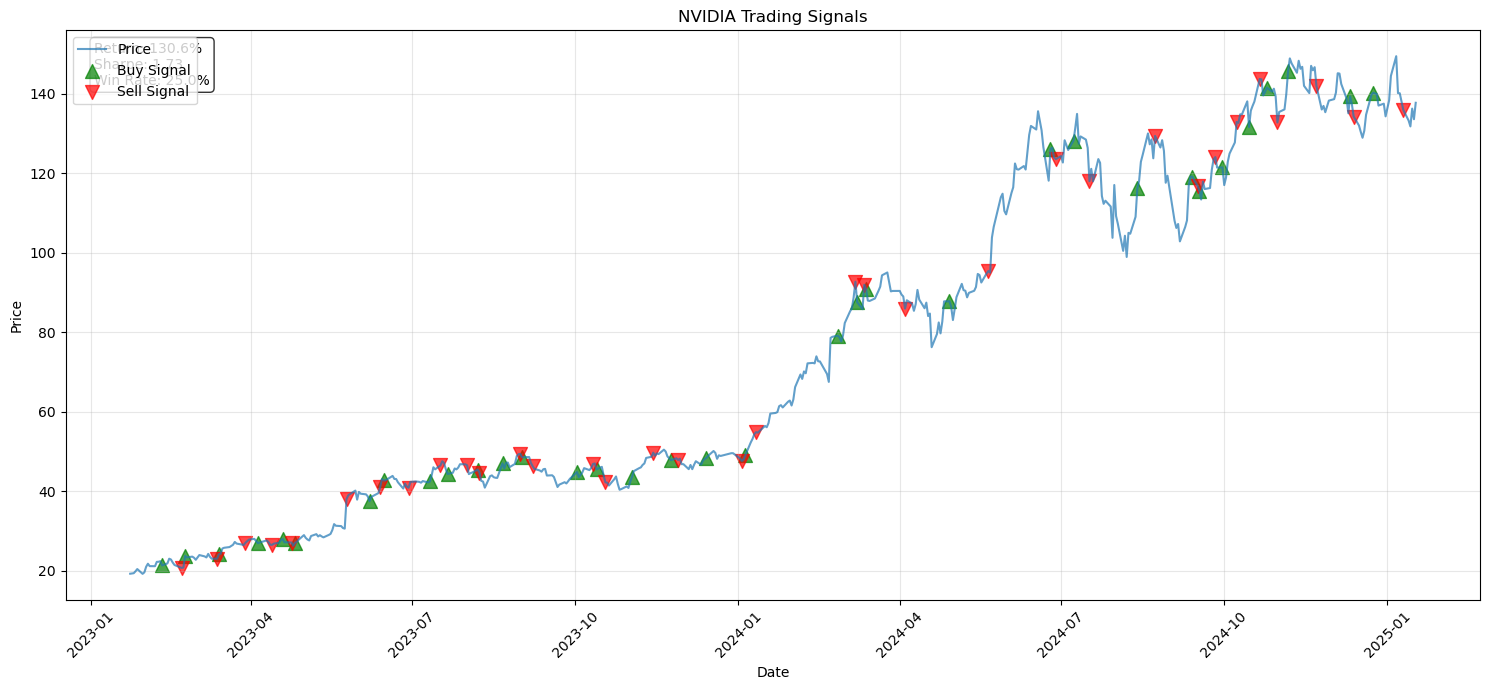

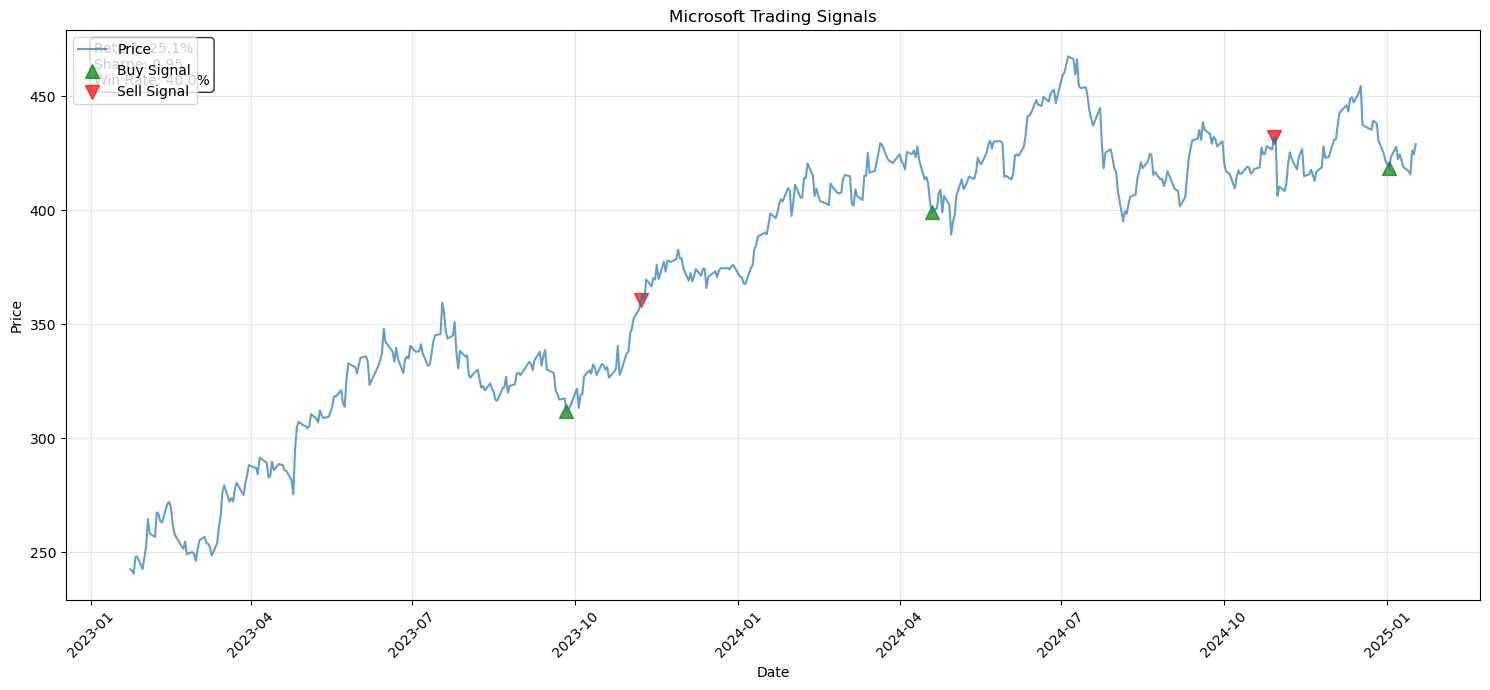

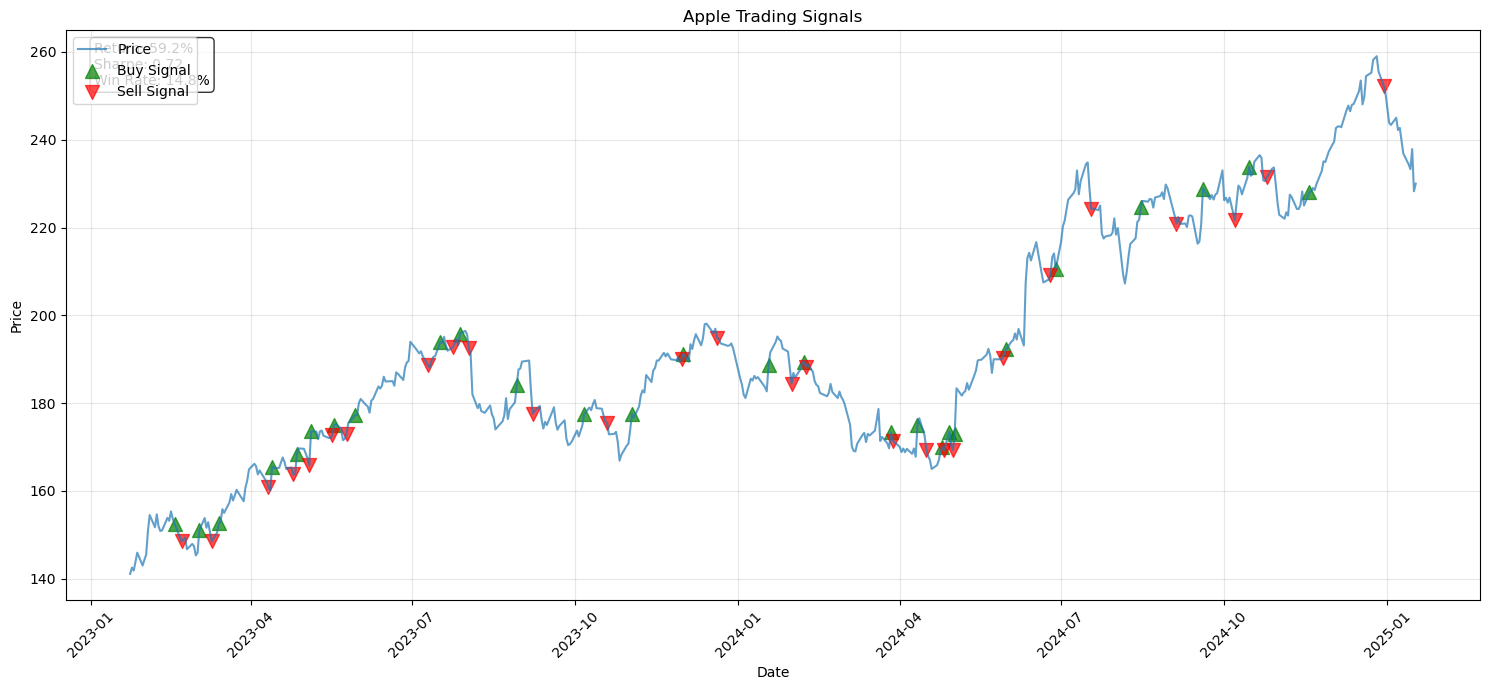

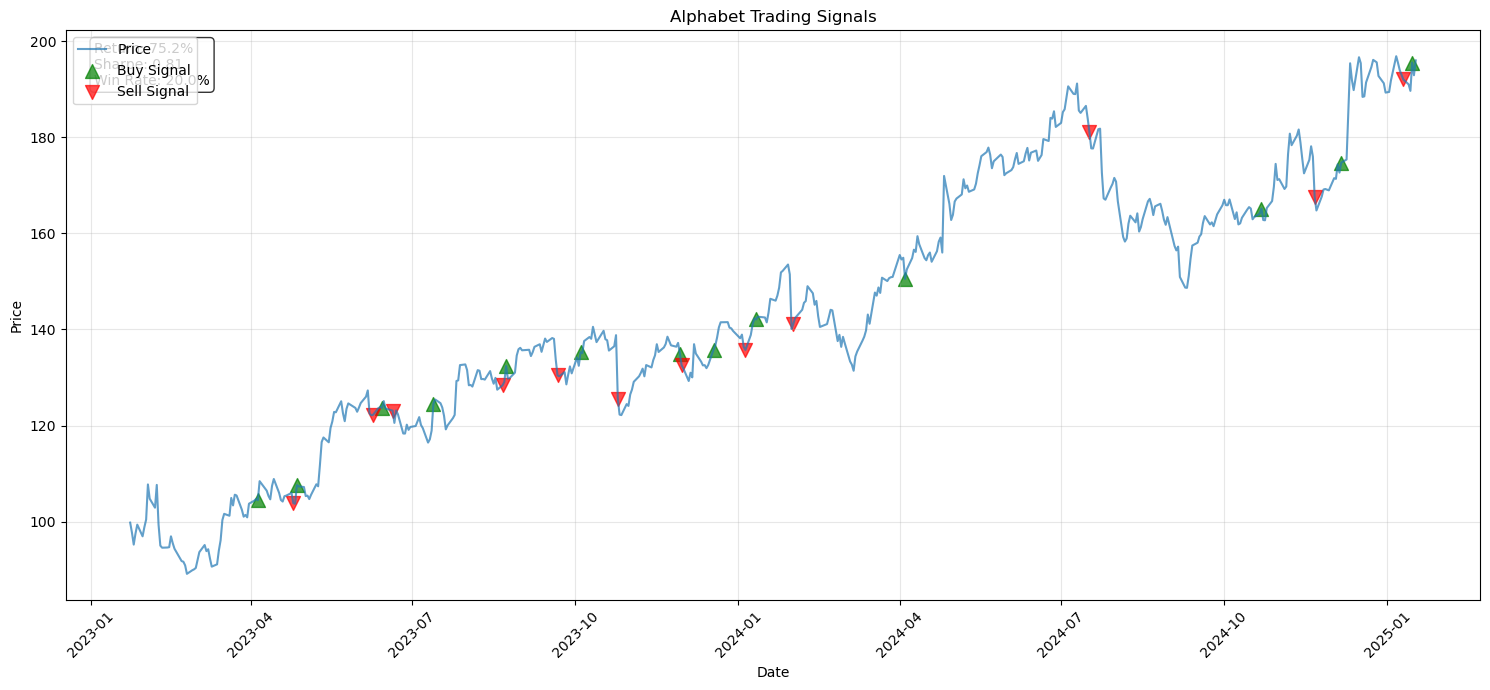

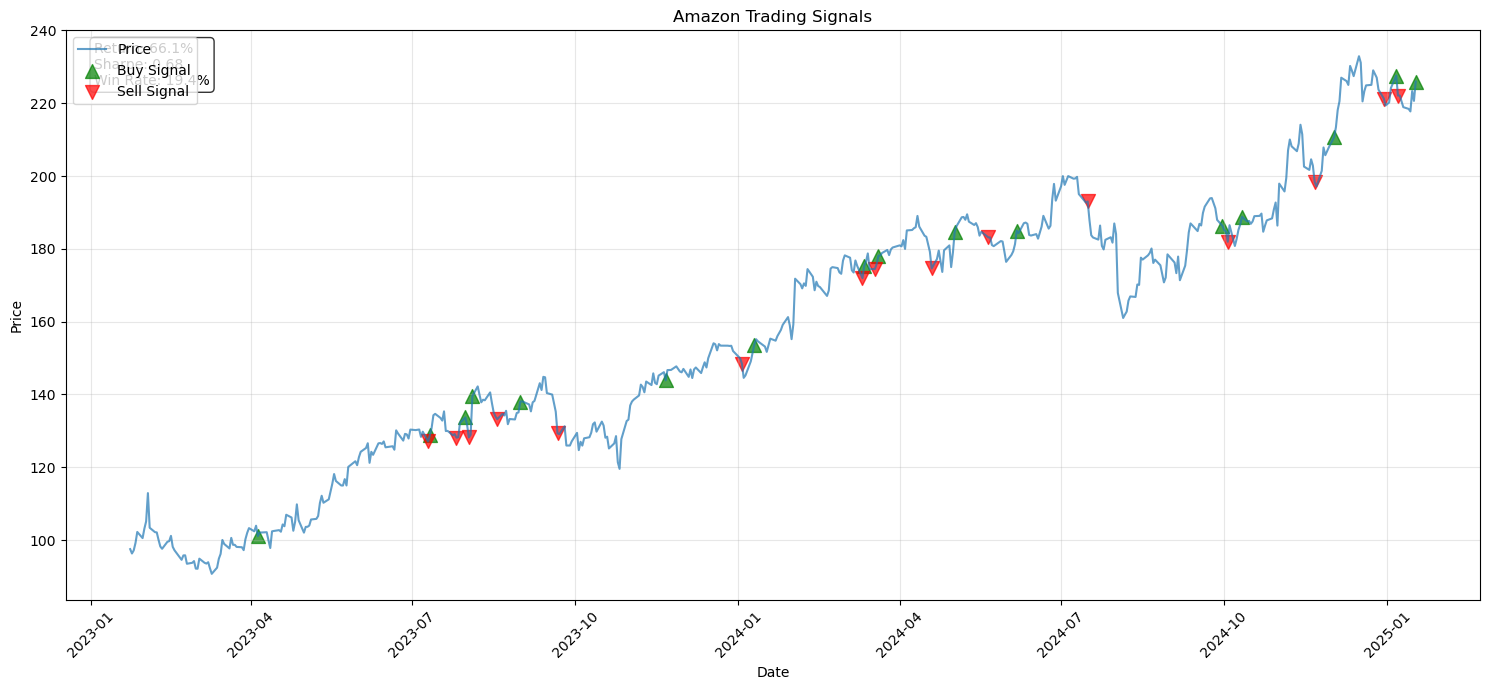

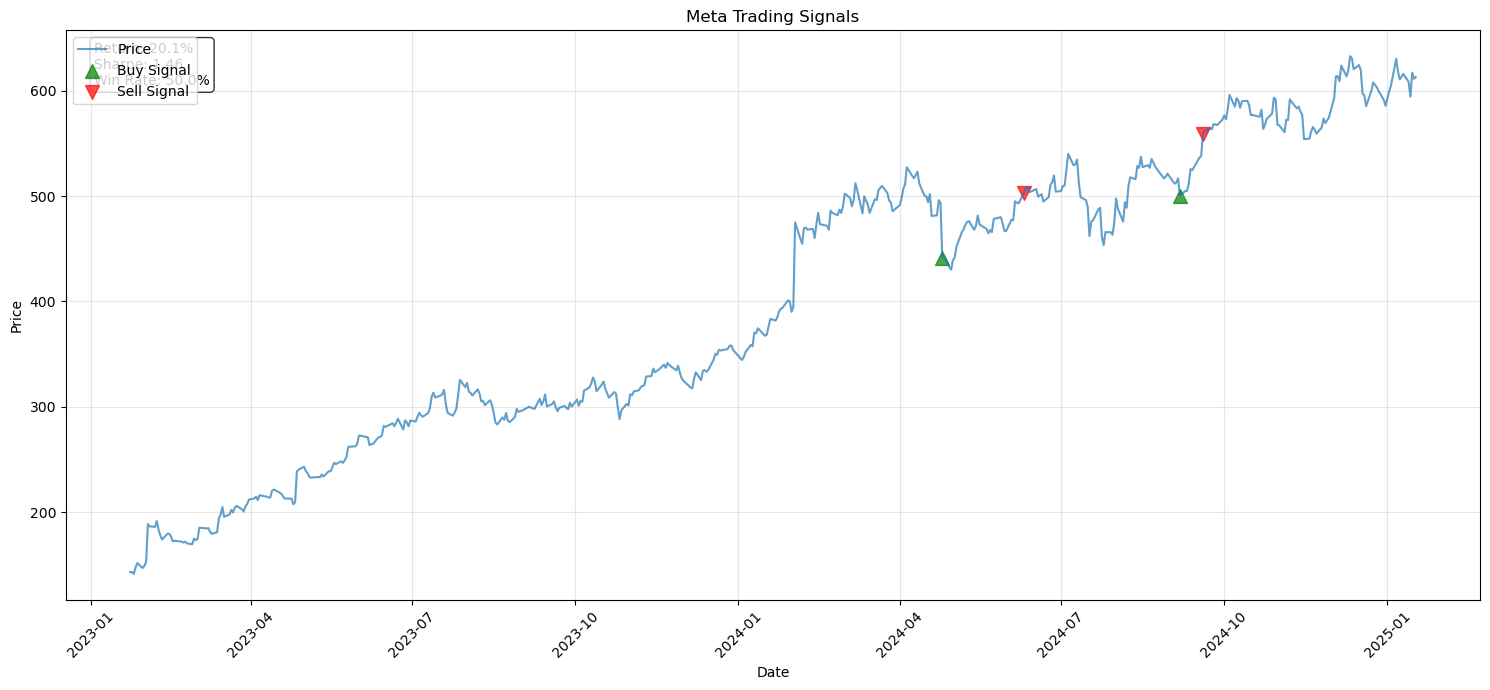

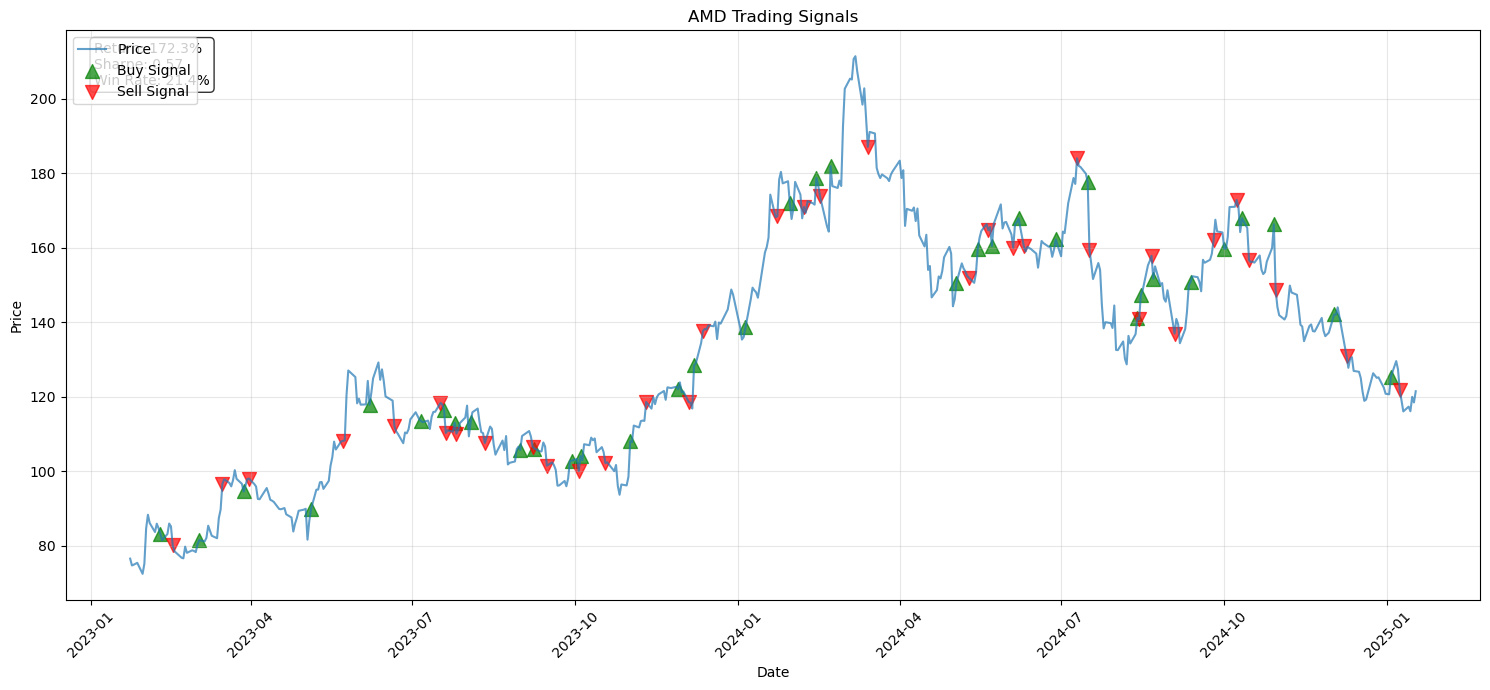

In [16]:
def plot_trading_signals(dfs, results, save_plots=False):
    """
    Plot trading signals for each stock with price data and signals
    
    Parameters:
    dfs (dict): Dictionary of dataframes with stock data
    results (dict): Dictionary of trading results
    save_plots (bool): Whether to save plots to files
    """
    #plt.style.use('seaborn')
    
    for company, df in dfs.items():
        # Create figure
        fig, ax = plt.subplots(figsize=(15, 7))
        
        # Plot price
        ax.plot(df.index, df['Close'], label='Price', alpha=0.7)
        
        # Get signals from results
        signals = results[company]['Trades']
        
        # Plot buy signals
        buy_signals = [trade for trade in signals if trade['Type'] == 'Buy']
        if buy_signals:
            buy_dates = [trade['Date'] for trade in buy_signals]
            buy_prices = [trade['Price'] for trade in buy_signals]
            ax.scatter(buy_dates, buy_prices, color='green', marker='^', 
                      s=100, label='Buy Signal', alpha=0.7)
        
        # Plot sell signals
        sell_signals = [trade for trade in signals if trade['Type'] == 'Sell']
        if sell_signals:
            sell_dates = [trade['Date'] for trade in sell_signals]
            sell_prices = [trade['Price'] for trade in sell_signals]
            ax.scatter(sell_dates, sell_prices, color='red', marker='v',
                      s=100, label='Sell Signal', alpha=0.7)
        
        # Customize plot
        ax.set_title(f'{company} Trading Signals')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)
        
        # Rotate x-axis labels
        plt.xticks(rotation=45)
        
        # Add performance metrics
        metrics = f"Return: {results[company]['Return (%)']:.1f}%\n"
        metrics += f"Sharpe: {results[company]['Sharpe Ratio']:.2f}\n"
        metrics += f"Win Rate: {results[company]['Win Rate (%)']:.1f}%"
        
        # Add text box with metrics
        plt.text(0.02, 0.98, metrics,
                transform=ax.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        
        if save_plots:
            plt.savefig(f'{company}_signals.png', dpi=300, bbox_inches='tight')
        
        plt.show()

# Call the function with your results
plot_trading_signals(dfs, results)

## Conclusion:
I think these strategies are solid for each of the companies they are assigned to, having produced high return rates and sharpe ratios with a good number of successful trades. However, if we had a way to access real- time news headlines, analyse them using a sentiment analyser, and take this into account while making trades, we would certainly be able to make more successful trades since they are backed by real- time news info. I have provided extra code that can take in real- time news data using an API from NewsAPI, and evaluate it using a huggingface model. This could be used as a factor in generating trade signals. For example, just before making a decision, if we find news that goes against making that decision, we could wait a little bit until making sure that we have more news supporting making the decision.


In [17]:
import requests
from transformers import BertTokenizer, BertForSequenceClassification
from torch import nn
import torch

def get_financial_news(company_name, api_key):
    url = f'https://newsapi.org/v2/everything?q={company_name}&apiKey={api_key}'
    
    # Make the API request
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data['articles']  # Returns a list of articles
    else:
        raise Exception(f"Error fetching data from NewsAPI: {response.status_code}")


'import requests\nfrom transformers import BertTokenizer, BertForSequenceClassification\nfrom torch import nn\nimport torch\n\ndef get_financial_news(company_name, api_key):\n    url = f\'https://newsapi.org/v2/everything?q={company_name}&apiKey={api_key}\'\n    \n    # Make the API request\n    response = requests.get(url)\n    if response.status_code == 200:\n        data = response.json()\n        return data[\'articles\']  # Returns a list of articles\n    else:\n        raise Exception(f"Error fetching data from NewsAPI: {response.status_code}")\n'

In [18]:


# Load the FinBERT model and tokenizer
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

def analyze_sentiment(news_articles):
    sentiments = []
    
    for article in news_articles:
        text = article['title'] 
        # Tokenize the text
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        
        # Get predictions
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            
        # Apply softmax to get probabilities
        softmax = nn.Softmax(dim=1)
        probs = softmax(logits)
        sentiment = torch.argmax(probs, dim=1).item()
        
        # Map sentiment: 0 = negative, 1 = neutral, 2 = positive
        sentiment_label = ["negative", "neutral", "positive"]
        sentiments.append((article['title'], sentiment_label[sentiment]))
    
    return sentiments


SyntaxError: EOF while scanning triple-quoted string literal (477740956.py, line 30)

In [ ]:
def analyze_company_sentiment(company_name, api_key):
    # Step 1: Retrieve news articles related to the company
    articles = get_financial_news(company_name, api_key)
    
    # Step 2: Analyze the sentiment of each article
    sentiments = analyze_sentiment(articles)
    
    # Step 3: Output the results
    positive_sentiment_count = sum(1 for _, sentiment in sentiments if sentiment == "positive")
    negative_sentiment_count = sum(1 for _, sentiment in sentiments if sentiment == "negative")
    
    print(f"Positive Sentiment Count: {positive_sentiment_count}")
    print(f"Negative Sentiment Count: {negative_sentiment_count}")
    
    return positive_sentiment_count, negative_sentiment_count


In [ ]:
#Example for Meta
company_name = "Meta"  
api_key = "65ec289157754818bcf0546c2bcefc6c"  
    
analyze_company_sentiment(company_name, api_key)

In [ ]:
def meta_with_sentiment(data, company_name, api_key):
    # Step 1: Retrieve sentiment analysis from news
    positive_sentiment_count, negative_sentiment_count = analyze_company_sentiment(company_name, api_key)

    # Step 2: Calculate technical indicators
    data['RSI'] = calculate_rsi(data)
    data['BB_Upper'], data['BB_Middle'], data['BB_Lower'] = calculate_bollinger_bands(data)

    # Step 3: Combine sentiment with technical analysis
    data['Signal'] = 0
    
    # Buy signal based on sentiment (positive sentiment) and technical indicators
    if positive_sentiment_count > negative_sentiment_count:
        data.loc[(data['RSI'] < 30) & (data['Close'] < data['BB_Lower']), 'Signal'] = 1  # Buy signal
    
    # Sell signal based on sentiment (negative sentiment) and technical indicators
    if negative_sentiment_count > positive_sentiment_count:
        data.loc[(data['RSI'] > 70) & (data['Close'] > data['BB_Upper']), 'Signal'] = -1  # Sell signal
    
    # Neutral signal if sentiment is balanced or neutral
    if positive_sentiment_count == negative_sentiment_count or positive_sentiment_count == 0:
        data['Signal'] = 0  # Neutral signal (hold)

    return data




This strategy combines the initial trading strategy with news sentiment, and may be more effective than the initial one. However, we cannot backtest this, as the news we have is real - time, and we wouldn't be able to try with old news.